In [63]:
import numpy as np
import pandas as pd
import time
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, BicScore,BdeuScore,K2Score
import copy
import os

# Generate Dataset

In [627]:
def pair_dataset(df, df_all): 
    """
    # Function
    Pair the 15 feature for left and right images according to dataset
    # Parameters
    df: DataFrame
        df is the dataset that contains left image name, right image name and verification label
    df_all: DataFrame
        df_all contains all features for each image. It has 16 columns. The first column is image name, 
        the remainings are 15 features
    """
    arr_all=np.array(df_all)
    arr=np.array(df)
    left=np.zeros((arr.shape[0],15))
    right=np.zeros((arr.shape[0],15))
    label=np.zeros((arr.shape[0],1))
    dic={}
    for row in arr_all:# create dictionary whose key is image name, value is 15 image features
        dic[row[0]]=row[1:]
    for i in range(arr.shape[0]): # create two groups of 15-feature, and a verification label
        row=arr[i,:]
        if (row[1] not in dic) or (row[2] not in dic):
            continue
        left[i,:]=dic[row[1]]-1 # left img 
        right[i,:]=dic[row[2]]-1 # right img 
        label[i]=row[3]
    res=np.hstack((label,left,right)) # joint three groups
    return pd.DataFrame(res)


In [151]:
def modifyDataframe(df, single=True, haswriter=False):
    """
    # Function
    Change the column name of DataFrame according to the settings
    # Parameters
    df: The original DataFrame
    single: If true, df has only one group of 15 features; otherwise, df has two groups of 15 features
    haswriter: Only works when single=True. If it is true, add writer id as first column. Otherwise, only change
    column names
    """
    if single:
        if haswriter:
            data=np.array(df)
            for i in range(data.shape[0]):
                s=data[i,0]
                data[i,0]=int(s[0:4])
            data=data.astype(int)
            df=pd.DataFrame(data,columns=['W','L1','L2','L3','L4','L5','L6','L7','L8','L9',
                                      'L10','L11','L12','L13','L14','L15'])
        else:
            data=np.array(df)
            df=df.drop(columns=[df.columns[0]])
            df.columns=['L1','L2','L3','L4','L5','L6','L7','L8','L9',
                                      'L10','L11','L12','L13','L14','L15']
    else:
        df.columns=['W','L1','L2','L3','L4','L5','L6','L7','L8','L9','L10','L11','L12','L13','L14','L15',
                         'R1','R2','R3','R4','R5','R6','R7','R8','R9','R10','R11','R12','R13','R14','R15']
    return df


In [153]:

cwd = os.getcwd()
df_all=pd.read_csv(cwd+"/15features.csv") # Dataframe of AND features
df_15features=modifyDataframe(df_all)
# training data in seen
df_seen_tr=pd.read_csv(cwd+"/seen-dataset/dataset_seen_training_siamese.csv")
df_seen_tr=pair_dataset(df_seen_tr, df_all)
df_seen_tr=modifyDataframe(df_seen_tr, False) # change feature names
# validation data in seen
df_seen_va=pd.read_csv(cwd+"/seen-dataset/dataset_seen_validation_siamese.csv")
df_seen_va=pair_dataset(df_seen_va, df_all)
df_seen_va=modifyDataframe(df_seen_va, False) # change feature names
# training data in unseen
df_unseen_tr=pd.read_csv(cwd+"/unseen-dataset/dataset_seen_training_siamese.csv")
df_unseen_tr=pair_dataset(df_unseen_tr, df_all)
df_unseen_tr=modifyDataframe(df_unseen_tr, False)
# validation data in unseen
df_unseen_va=pd.read_csv(cwd+"/unseen-dataset/dataset_seen_validation_siamese.csv")
df_unseen_va=pair_dataset(df_unseen_va, df_all)
df_unseen_va=modifyDataframe(df_unseen_va, False)
# traning data in shuffled
df_shuffle_tr=pd.read_csv(cwd+"/shuffled-dataset/dataset_seen_training_siamese.csv")
df_shuffle_tr=pair_dataset(df_shuffle_tr, df_all)
df_shuffle_tr=modifyDataframe(df_shuffle_tr, False)
# validation data in shuffled
df_shuffle_va=pd.read_csv(cwd+"/shuffled-dataset/dataset_seen_validation_siamese.csv")
df_shuffle_va=pair_dataset(df_shuffle_va, df_all)
df_shuffle_va=modifyDataframe(df_shuffle_va, False)

# Build and train BN

In [119]:
from pgmpy.estimators import BayesianEstimator,MaximumLikelihoodEstimator


In [602]:
def modifyGraph(graph, feature_char='L'):
    """
    # Function
    Modify the feature names
    # Parameter
    graph: list of edges of original graph
    """
    g=[]
    for e in graph:
        par=feature_char+e[0][1:]
        child=feature_char+e[1][1:]
        g.append((par,child))
    return g
def getNodeparents(graph):
    par={}
    for g in graph:
        if g[1] not in par:
            par[g[1]]=[g[0]]
        else:
            par[g[1]].append(g[0])
    size={}
    for key, val in par.items():
        size[key]=len(val)
    return size,par
def getAdjList(graph):
    child={}
    for g in graph:
        if g[0] not in child:
            child[g[0]]=[g[1]]
        else:
            child[g[0]].append(g[1])
    return child
def get_BayesianModel(graph1, graph_toVerify):
    """
    # Function
    Create whole list of edges for Bayesian modeling
    # Parameter
    graph1: list of edges of left image
    graph_toVerify: list of edges connecting feature nodes to verification node
    """
    graph2=modifyGraph(graph1, 'R') # the mirror image of graph1
    model=BayesianModel(graph1+graph2+graph_toVerify)
    return model
def Log_CPDproduct(model, df, prob_hypo, verbose=False):
    """
    # Function
    Calculate the joint probability by multiplying CPDs evalated at given variable values
    # Parameter
    model: Bayesian model
    df: DataFrame
        Traning dataset
    prob_hypo: numpy array of probability of hypothesis
    verbose: boolean
        determine whether to print details
    """
    cpd_list=model.get_cpds()
    data=np.array(df)
    col_name=list(df.columns)
    dic_row={}# a dict stores img features(L1,R1,...) but verification
    y_pred=np.zeros(data.shape[0]) # store predicted value
    for i in range(data.shape[0]):#data.shape[0]
        row=data[i,:]
        for n in range(1,len(col_name)): 
            dic_row[col_name[n]]=int(data[i,n])
        
        # Add log cpd values to get log(joint probability)
        log_joint=[-1,-1] # store log joint probability for two verification values [0,1]
        for verify in [0,1]:
            dic_row['W']=verify
            log_cpd_prod=0
            for j in range(len(cpd_list)):# loop all the CPD tables in the BN
                cpd=cpd_list[j]
                cpd_key=cpd.variables # ['R1','L1','W'...]
                cpd_val=cpd.values # cpd table
                temp_table=cpd_val
                for k in range(len(cpd_key)):# check CPD value in one table
                    val=dic_row[cpd_key[k]] # value for each variable in cpd_key list
                    temp_table=temp_table[int(val)] # check next level in table, the last one is a scalar CPD value
                log_cpd_prod=log_cpd_prod+np.log(temp_table)
            log_joint[verify]=log_cpd_prod
        log_joint=np.array(log_joint) # convert to numpy array
        log_marg_verify=np.log(prob_hypo)# numpy array
        log_likelihood=log_joint-log_marg_verify
#         print(log_joint)
#         print(log_marg_verify)
#         print(log_likelihood)
        if log_likelihood[0]>log_likelihood[1]: # first element is diff writer, second is same writer
            y_pred[i]=0
            if verbose:
                print(str(i)+"th: ","diff writer")
        elif log_likelihood[0]<log_likelihood[1]:
            y_pred[i]=1
            if verbose:
                print(str(i)+"th: ","same writer")
        else:
            if verbose:
                print(str(i)+"th: ","equal")
    return y_pred
def getAccuracy(df,y_pred):
    """
    # Function
    Calculate accruacy of prediction
    # Parameter
    df: DataFrame
        the original dataset that contains true labels
    y_pred: numpy array
        predicted label
    """
    y=np.array(df['W'])
    right=np.where(y==y_pred)[0].shape[0]
    return right/y.shape[0]
def get_prob_indata(df):
    """
    # Functions
    Calculate probability of hypothesis
    # Parameter
    df: DataFrame
        original dataset
    """
    arr=np.array(df["W"])
    p_diff=np.where(arr==0)[0].shape[0]/arr.shape[0]
    return np.array([p_diff,1-p_diff])

In [87]:
# Search best model with 15 features
est = HillClimbSearch(df_15features, scoring_method=BicScore(df_15features))
best_model=est.estimate(max_indegree=None)
print(best_model.edges())
print(BicScore(df_15features).score(best_model))
# BicScore(df_seen_tr).score(model)

[('L1', 'L5'), ('L2', 'L1'), ('L3', 'L4'), ('L3', 'L7'), ('L3', 'L1'), ('L3', 'L2'), ('L3', 'L9'), ('L3', 'L14'), ('L4', 'L14'), ('L4', 'L15'), ('L4', 'L11'), ('L5', 'L10'), ('L6', 'L12'), ('L6', 'L3'), ('L6', 'L7'), ('L6', 'L9'), ('L6', 'L11'), ('L6', 'L2'), ('L6', 'L10'), ('L6', 'L4'), ('L6', 'L5'), ('L6', 'L14'), ('L7', 'L8'), ('L11', 'L15'), ('L12', 'L5'), ('L13', 'L6'), ('L13', 'L12'), ('L13', 'L3'), ('L14', 'L15'), ('L14', 'L11'), ('L14', 'L10'), ('L14', 'L12'), ('L15', 'L10'), ('L15', 'L2')]
-140447.85183156087


### Connect one feature node to verification node

In [614]:
# Connect one feature node to verifiction node for both left and right image. Compare accuracy, inferring time
acc_tr=[]
acc_va=[]
time_train=[]
time_infer=[]
df_tuple=(df_seen_tr,df_seen_va)
for i in range(1,16):
    graph_toVerify=[('L'+str(i), 'W'), ('R'+str(i), 'W')] # connect feature nodes to verification node
    model=get_BayesianModel(list(best_model.edges()), graph_toVerify) # build model from the complete graph
    time_s=time.time()
    estimator = MaximumLikelihoodEstimator(model, df_tuple[0]) # train model(cal cpds)
    cpd_est=estimator.get_parameters()
    time_e=time.time()
    time_train.append(time_e-time_s)
    
    time_s=time.time()
    model.add_cpds(*cpd_est)
    inference=VariableElimination(model)
    y_pred=Log_CPDproduct(model, df_tuple[1], get_prob_indata(df_tuple[0]))# predict labels
    time_e=time.time()
    time_infer.append(time_e-time_s)
    
    acc=getAccuracy(df_tuple[1],y_pred)# calcualte accuracy
    acc_va.append(acc)
    print(str(i)+"th feature connects verification, accuracy: ",acc)

1th feature connects verification, accuracy:  0.6567328918322296
2th feature connects verification, accuracy:  0.7163355408388521


/Users/huo/.pyvenv/pgmpy/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


3th feature connects verification, accuracy:  0.5573951434878587
4th feature connects verification, accuracy:  0.7306843267108167
5th feature connects verification, accuracy:  0.5011037527593819
6th feature connects verification, accuracy:  0.7417218543046358
7th feature connects verification, accuracy:  0.3852097130242826
8th feature connects verification, accuracy:  0.4227373068432671
9th feature connects verification, accuracy:  0.5253863134657837
10th feature connects verification, accuracy:  0.37527593818984545
11th feature connects verification, accuracy:  0.46467991169977924
12th feature connects verification, accuracy:  0.8620309050772627
13th feature connects verification, accuracy:  0.8289183222958058
14th feature connects verification, accuracy:  0.25055187637969095
15th feature connects verification, accuracy:  0.3454746136865342


In [529]:
print("Average training time: ",np.mean(np.array(time_train)))
print("Average inferring time: ",np.mean(np.array(time_infer)))

Average training time:  0.1868833541870117
Average inferring time:  6.045334688822428


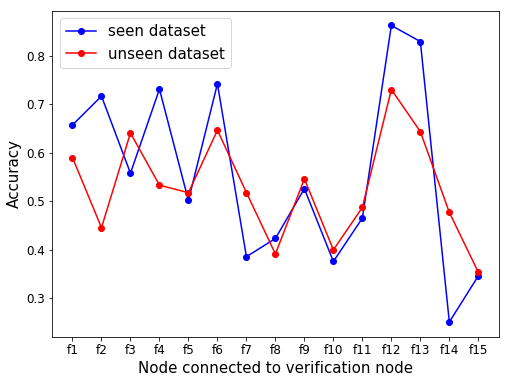

In [532]:
import matplotlib.pyplot as plt

yplot=acc_seen_va
yplot2=acc_unseen_va
xplot=[]

for i in range(len(yplot)):
    xplot.append("f"+str(i+1))
plt.figure(figsize=(8,6))
plt.plot(xplot,yplot,color='b',marker='o',label="seen dataset")
plt.plot(xplot,yplot2,color='r',marker='o',label="unseen dataset")
plt.xlabel("Node connected to verification node", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.tick_params(labelsize=12)
plt.legend(fontsize=15)

plt.show()

### Connect multiple feature nodes to verification node

In [628]:
df_tuple=(df_seen_tr,df_seen_va)
graph_toVerify=[('L13', 'W'),('R13', 'W'),('L12', 'W'),('R12', 'W'),('L6', 'W'),('R6', 'W'),
                ('L7', 'W'),('R7', 'W')] # feature nodes connected to the verification node
model=get_BayesianModel(list(best_model.edges()), graph_toVerify) # build model from the complete graph
time_s=time.time()
estimator = MaximumLikelihoodEstimator(model, df_tuple[0]) # train model(cal cpds)
cpd_est=estimator.get_parameters()
time_e=time.time()
print("Training time: ", time_e-time_s)


time_s=time.time()
model.add_cpds(*cpd_est)
inference=VariableElimination(model)
y_pred=Log_CPDproduct(model, df_tuple[1], get_prob_indata(df_tuple[0]))
time_e=time.time()
print("Inferring time: ", time_e-time_s)

print("Accuracy: ",getAccuracy(df_tuple[1],y_pred))

Training time:  20.83700203895569


/Users/huo/.pyvenv/pgmpy/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


Inferring time:  0.3515510559082031
Accuracy:  0.9679911699779249
